# Selecting an alternative type for a column

Sometimes ptype infers a type for a column which we know to be incorrect. In this situation, ptype allows us to select a _different_ column type and still take advantage of its per-row type inference (conditional on the new type of the column) to identify anomalous and missing values. To illustrate this, we present the following two scenarios:
- We employ ptype on a toy example constructed using mostly 4-digit years (e.g. 1991) and an amalous 2-digit year (99). We assume that the user runs ptype on the data frame and inspects the inferred schema. The schema classifies the column as `integer` rather than `date-iso-8601`. The user then indicates to ptype that the column should be treated as `date-iso-8601` and notices that this lets ptype detect `99` as an anomalous entry.
- For a more realistic example, we consider the task of measuring the association between two non-numerical data columns of the Grub Damage dataset, which is a collection of information about grass grub numbers, irrigation and damage. The user loads the dataset into a dataframe using Pandas `read_csv` and transforms the data frame using the schema inferred by ptype to calculate the Cramérs V statistic between the two columns. However, ptype misclassifies one of the columns, which causes the measure to be undefined. The user is able to correct ptype's prediction and then correctly calculate the Cramérs V on the newly transformed dataframe.

In [1]:
# Preamble to run notebook in context of source package.
import sys
sys.path.insert(0, '../')

### Toy Example
Here, we construct a Pandas dataframe containing 9 data entries valued between 1991 and 1999, where in one row 1999 is encoded by 99. Note that we set `dtype` to `str` so that ptype can infer a schema based on this untyped (string) representation.

In [2]:
import pandas as pd

x = ['1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '99']
column = 'year'

df = pd.DataFrame(x, dtype='str', columns=[column])
df

,year
0,1991
1,1992
2,1993
3,1994
4,1995
5,1996
6,1997
7,1998
8,99


First, we show that the default behaviour of ptype is to infer that the column contains integers rather than dates.

In [3]:
from ptype.Ptype import Ptype

ptype = Ptype()
schema = ptype.schema_fit(df)
schema.show()

,year
type,integer
normal values,"[1991, 1992, 1993, 1994, 1995, 1996, 1997, 199..."
missing values,[]
anomalous values,[]


Notice that the column's type is reported as integer and no missing or anomalous entries are detected. 

We can now change how the column is interpreted by interacting with ptype:

In [4]:
schema.cols[column].reclassify('date-iso-8601')

As a result of this interaction, the inferred schema is modified as follows:

In [5]:
schema.show()

,year
type,date-iso-8601
normal values,"[1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998]"
missing values,[]
anomalous values,[99]


Now that the user has specified that the column is of type `date-iso-8601`, ptype can update its beliefs regarding anomalous values. As we can see, 99 is now classified as an anomalous entry since it does not fit the corresponding Probabilistic Finite-State Machine, i.e., the machine expects 4-digit formatted values between 1900 and 2099.

In [6]:
# repair 99 as 1999?

### Real-world Example
In this example, we use the [Grub Damage](https://www.openml.org/d/338) dataset to analyze the relationship between grass grub numbers, irrigation and damage. We will focus on the task of finding the association between the `zone` and `GG_new` columns.

Note that the `GG_new` column is an ordinal variable.

In [7]:
df = pd.read_csv('../data/grub-damage.csv', encoding="ISO-8859-1", dtype='str')
df.head()

,year_zone,year,strip,pdk,damage_rankRJT,damage_rankALL,dry_or_irr,zone,GG_new
0,6f,86,3,1,1,0,D,F,low
1,6f,86,3,2,0,0,D,F,high
2,6f,86,3,3,1,1,D,F,high
3,6f,86,3,4,1,0,D,F,high
4,6f,86,3,5,0,0,D,F,low


First, we use ptype to inspect the properties of this dataset. 

In [8]:
ptype = Ptype()

schema = ptype.schema_fit(df)
schema.show()

,year_zone,year,strip,pdk,damage_rankRJT,damage_rankALL,dry_or_irr,zone,GG_new
type,string,integer,integer,integer,integer,integer,string,boolean,string
normal values,"[0c, 0f, 0m, 1c, 1f, 1m, 2c, 2f, 2m, 6c, 6f, 6...","[86, 87, 88, 89, 90, 91, 92]","[1, 10, 2, 3, 4, 5, 6, 7, 9]","[0, 1, 2, 3, 4, 5]","[0, 1, 2, 3, 4, 5]","[0, 1, 2, 3, 4, 5]","[B, D, O]",[F],"[average, high, low, veryhigh]"
missing values,[],[],[],[],[],[],[],[],[]
anomalous values,[],[],[],[],[],[],[],"[C, M]",[]


As you can see, ptype predicts the type of the `zone` column as `boolean` and labels the values `C` and `M` as anomalies. Note that we can confirm that these values should be consider “normal“ values by consulting the metadata, which states "8. zone - position of paddock (F: foothills, M: midplain, C: coastal) - enumerated".

If we accept ptype‘s analysis as it stands, we can obtain the following data frame:

In [9]:
df2 = schema.transform(df)
df2

,year_zone,year,strip,pdk,damage_rankRJT,damage_rankALL,dry_or_irr,zone,GG_new
0,6f,86,3,1,1,0,D,False,low
1,6f,86,3,2,0,0,D,False,high
2,6f,86,3,3,1,1,D,False,high
3,6f,86,3,4,1,0,D,False,high
4,6f,86,3,5,0,0,D,False,low
...,...,...,...,...,...,...,...,...,...
150,2c,92,9,4,1,1,B,<NA>,average
151,2c,92,10,1,3,3,O,<NA>,high
152,2c,92,10,2,1,1,D,<NA>,average
153,2c,92,10,3,2,2,O,<NA>,average


However, since the anomalous values have now been replaced by `<NA>`, the Cramers V measure between `zone` and `GG_new columns` is undefined:

In [10]:
# NBVAL_IGNORE_OUTPUT
import numpy as np
import scipy.stats as ss

# see https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V
def cramers_corrected_stat(x, y):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))


cramers_corrected_stat(df2['zone'], df2['GG_new'])

/Users/tceritli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


nan

As before, we can interact further with ptype to fix its predictions for the `zone` column.

In [11]:
schema.cols['zone'].reclassify('string')
schema.show()

,year_zone,year,strip,pdk,damage_rankRJT,damage_rankALL,dry_or_irr,zone,GG_new
type,string,integer,integer,integer,integer,integer,string,string,string
normal values,"[0c, 0f, 0m, 1c, 1f, 1m, 2c, 2f, 2m, 6c, 6f, 6...","[86, 87, 88, 89, 90, 91, 92]","[1, 10, 2, 3, 4, 5, 6, 7, 9]","[0, 1, 2, 3, 4, 5]","[0, 1, 2, 3, 4, 5]","[0, 1, 2, 3, 4, 5]","[B, D, O]","[C, F, M]","[average, high, low, veryhigh]"
missing values,[],[],[],[],[],[],[],[],[]
anomalous values,[],[],[],[],[],[],[],[],[]


As we can see, the row type predictions have been updated according to the new column type, and so `C` and `M` are now classified as normal values. Now we can tranform the dataframe according to the revised schema.

In [12]:
df2 = schema.transform(df)
df2

,year_zone,year,strip,pdk,damage_rankRJT,damage_rankALL,dry_or_irr,zone,GG_new
0,6f,86,3,1,1,0,D,F,low
1,6f,86,3,2,0,0,D,F,high
2,6f,86,3,3,1,1,D,F,high
3,6f,86,3,4,1,0,D,F,high
4,6f,86,3,5,0,0,D,F,low
...,...,...,...,...,...,...,...,...,...
150,2c,92,9,4,1,1,B,C,average
151,2c,92,10,1,3,3,O,C,high
152,2c,92,10,2,1,1,D,C,average
153,2c,92,10,3,2,2,O,C,average


And finally we can calculate the Cramers V statistic as desired:

In [13]:
cramers_corrected_stat(df2['zone'], df2['GG_new'])

0.3074039662588285

### Housing Price Dataset

In [14]:
# data source: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
df = pd.read_csv('../data/housing_price.csv', dtype='str', keep_default_na=False)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000


In [15]:
features = ['1stFlrSF', '2ndFlrSF', 'GrLivArea', 'HalfBath']
target = ['SalePrice']

X = df[features]
y = df[target]

df = df[features+target]
df.head()

,1stFlrSF,2ndFlrSF,GrLivArea,HalfBath,SalePrice
0,856,854,1710,1,208500
1,1262,0,1262,0,181500
2,920,866,1786,1,223500
3,961,756,1717,0,140000
4,1145,1053,2198,1,250000


In [16]:
schema = ptype.schema_fit(df)
schema.show()

,1stFlrSF,2ndFlrSF,GrLivArea,HalfBath,SalePrice
type,integer,integer,integer,boolean,integer
normal values,"[1001, 1002, 1003, 1004, 1005, 1006, 1007, 100...","[0, 1000, 1001, 1015, 1017, 1020, 1028, 1031, ...","[1002, 1003, 1004, 1005, 1006, 1008, 1012, 101...","[0, 1]","[100000, 101000, 101800, 102000, 102776, 10300..."
missing values,[],[],[],[],[]
anomalous values,[],[],[],[2],[]


In [17]:
df2 = schema.transform(df)
df2.head()

,1stFlrSF,2ndFlrSF,GrLivArea,HalfBath,SalePrice
0,856,854,1710,True,208500
1,1262,0,1262,False,181500
2,920,866,1786,True,223500
3,961,756,1717,False,140000
4,1145,1053,2198,True,250000


In [18]:
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcdefaults()

lm = LinearRegression()

X = df2[features].values
y = df2[target].values

# lm.fit(X, y)
# y_hat = lm.predict(X)

# def scatter_plot(y, y_hat):
#     plt.figure(figsize=(12, 4))

#     sorted_indices = sorted(range(len(y)),key=y.__getitem__)
#     plt.scatter(range(len(y)), y[sorted_indices], label='Actual Price', s=10)
#     plt.scatter(range(len(y)), y_hat[sorted_indices], label='Predicted Price', s=10)

#     plt.title('Actual vs Fitted Values for SalePrice')
#     plt.xlabel('Item (sorted wrt actual price)')
#     plt.ylabel('Price (in dollars)')
#     plt.legend()
#     plt.show()

# scatter_plot(y, y_hat)

In [19]:
schema.cols['HalfBath'].reclassify('integer')
schema.show()

,1stFlrSF,2ndFlrSF,GrLivArea,HalfBath,SalePrice
type,integer,integer,integer,integer,integer
normal values,"[1001, 1002, 1003, 1004, 1005, 1006, 1007, 100...","[0, 1000, 1001, 1015, 1017, 1020, 1028, 1031, ...","[1002, 1003, 1004, 1005, 1006, 1008, 1012, 101...","[0, 1, 2]","[100000, 101000, 101800, 102000, 102776, 10300..."
missing values,[],[],[],[],[]
anomalous values,[],[],[],[],[]


In [20]:
df2 = schema.transform(df)
df2.head()

,1stFlrSF,2ndFlrSF,GrLivArea,HalfBath,SalePrice
0,856,854,1710,1,208500
1,1262,0,1262,0,181500
2,920,866,1786,1,223500
3,961,756,1717,0,140000
4,1145,1053,2198,1,250000


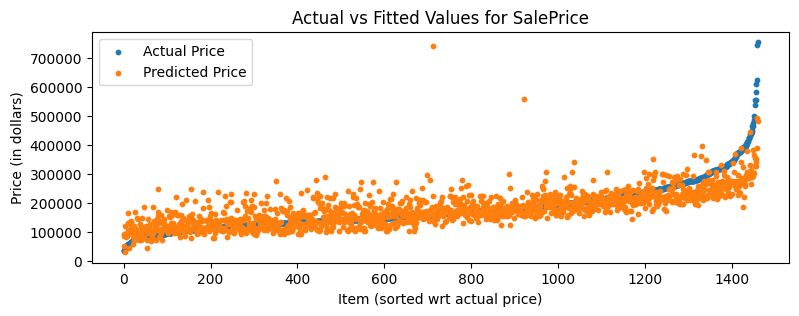

In [21]:
X = df2[features].values
y = df2[target].values

lm.fit(X, y)
y_hat = lm.predict(X)

def scatter_plot(y, y_hat):
    plt.figure(figsize=(9, 3))

    sorted_indices = sorted(range(len(y)),key=y.__getitem__)
    plt.scatter(range(len(y)), y[sorted_indices], label='Actual Price', s=10)
    plt.scatter(range(len(y)), y_hat[sorted_indices], label='Predicted Price', s=10)

    plt.title('Actual vs Fitted Values for SalePrice')
    plt.xlabel('Item (sorted wrt actual price)')
    plt.ylabel('Price (in dollars)')
    plt.legend()
    plt.show()

scatter_plot(y, y_hat)